In [ ]:
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install evaluate
# !pip install seqeval
# !pip install transformers[torch]

In [2]:
import torch
import numpy as np
from transformers import AutoModelForTokenClassification
import transformers
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer
import evaluate
from huggingface_hub import notebook_login
from tqdm.auto import tqdm

from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from huggingface_hub import Repository, get_full_repo_name

In [3]:
    notebook_login()

In [ ]:
dataset = load_dataset("go_emotions")

In [ ]:
print(dataset)
dataset['train']['labels']


LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

id2label = {idx:label for idx, label in enumerate(LABELS)}
label2id = {label:idx for idx, label in enumerate(LABELS)}

print(id2label)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


In [ ]:
# Define emotion-level scores based on F1-Score
emotion_scores = {
    'admiration': 0.65,
    'amusement': 0.80,
    'anger': 0.47,
    'annoyance': 0.34,
    'approval': 0.36,
    'caring': 0.39,
    'confusion': 0.37,
    'curiosity': 0.54,
    'desire': 0.49,
    'disappointment': 0.28,
    'disapproval': 0.39,
    'disgust': 0.45,
    'embarrassment': 0.43,
    'excitement': 0.34,
    'fear': 0.60,
    'gratitude': 0.86,
    'grief': 0.00,
    'joy': 0.51,
    'love': 0.78,
    'nervousness': 0.35,
    'neutral': 0.68,
    'optimism': 0.51,
    'pride': 0.36,
    'realization': 0.21,
    'relief': 0.15,
    'remorse': 0.66,
    'sadness': 0.49,
    'surprise': 0.50
}

sorted_emotions = sorted(emotion_scores.keys(), key=lambda x: emotion_scores[x], reverse=True)
sorted_emotions

['gratitude',
 'amusement',
 'love',
 'neutral',
 'remorse',
 'admiration',
 'fear',
 'curiosity',
 'joy',
 'optimism',
 'surprise',
 'desire',
 'sadness',
 'anger',
 'disgust',
 'embarrassment',
 'caring',
 'disapproval',
 'confusion',
 'approval',
 'pride',
 'nervousness',
 'annoyance',
 'excitement',
 'disappointment',
 'realization',
 'relief',
 'grief']

In [ ]:
# # Build a new dataset with examples ordered by F1-score
# ordered_examples = []
# for emotion in sorted_emotions:
#     indices = [i for i, label_list in enumerate(dataset['train']['labels']) if label2id[emotion] in label_list]
#     ordered_examples.extend(indices)

# curriculum_dataset = dataset['train'].select(ordered_examples)

In [ ]:
# curriculum_dataset['text']

In [ ]:
# curriculum_levels = [sorted_emotions[:10], sorted_emotions[10:20], sorted_emotions[20:]]
# curriculum_levels

# ### CHECK BACK ON THIS STYLE LATER

In [ ]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
from datasets import Value, Sequence, Features, ClassLabel
from transformers import DataCollatorWithPadding

def preprocess_function_goemotions(examples):
  text = examples["text"]
  encoding = tokenizer(text, truncation=True)
  label_mat = np.zeros((len(text), len(LABELS))).astype(np.float32)
  for i in range(len(text)):
    for l in examples['labels'][i]:
      label_mat[i][l] = 1.0
  label_mat = [[float(i) for i in row]  for row in label_mat]
  encoding['labels'] = label_mat

  return encoding


def tokenize_goemotions(dataset):
  tokenized_dataset = dataset.map(preprocess_function_goemotions, batched=True)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


  new_features = tokenized_dataset['train'].features.copy()
  new_features["labels"] = Sequence(Value("float32"))
  tokenized_dataset['train'] = tokenized_dataset['train'].cast(new_features)

  new_features = tokenized_dataset['validation'].features.copy()
  new_features["labels"] = Sequence(Value("float32"))
  tokenized_dataset['validation'] = tokenized_dataset['validation'].cast(new_features)

  new_features = tokenized_dataset['test'].features.copy()
  new_features["labels"] = Sequence(Value("float32"))
  tokenized_dataset['test'] = tokenized_dataset['test'].cast(new_features)
  return tokenized_dataset, data_collator



tokenized_dataset, data_collator = tokenize_goemotions(dataset)

# # Tokenize the curriculum dataset
# tokenized_curriculum_dataset = curriculum_dataset.map(preprocess_function_goemotions, batched=True)
# curriculum_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
list(emotion_scores.keys())

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise']

In [ ]:
# Code for re-ordering the samples in training data for curriculum learning
ordered_labels = sorted_emotions
ordered_dataset = []

for label in ordered_labels:
    label_id = label2id[label]
    for sample in tokenized_dataset["train"]:
        if label_id in sample['labels']:
            ordered_dataset.append(sample)

In [14]:
# Create a new dataset with ordered examples
import pandas as pd

ordered_dataset = Dataset.from_pandas(pd.DataFrame(ordered_dataset))

In [15]:
import evaluate
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score


# Adapted from https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels):
    threshold = 0.3
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    precision_macro_average = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro_average = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'precision': precision_macro_average,
               'recall': recall_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics



def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [16]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", problem_type="multi_label_classification",
    num_labels=28, id2label=id2label, label2id=label2id
)



training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="steps",
    # save_strategy="steps",
    eval_steps=500,
    metric_for_best_model="f1",
    warmup_ratio = 0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ordered_dataset,
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
trainer

In [19]:
trainer.train()

Step,Training Loss,Validation Loss,F1,Precision,Recall,Roc Auc,Accuracy
500,0.176700,0.143094,0.053865,0.054068,0.056401,0.521903,0.272208
1000,0.123200,0.105190,0.233391,0.377438,0.224396,0.604099,0.434759
1500,0.096900,0.094408,0.404296,0.496264,0.381501,0.681906,0.459823
2000,0.082300,0.090993,0.445688,0.472860,0.442247,0.711048,0.452083
2500,0.074400,0.090954,0.445830,0.462933,0.448279,0.713209,0.438445
3000,0.060500,0.098410,0.458136,0.470996,0.460201,0.718700,0.425544
3500,0.050200,0.099995,0.460379,0.458022,0.470074,0.724164,0.433100
4000,0.046000,0.105786,0.458616,0.498607,0.449228,0.712862,0.420199
4500,0.034400,0.114029,0.460112,0.477060,0.469677,0.723204,0.418356
5000,0.030400,0.117648,0.471487,0.463028,0.495675,0.735554,0.405455


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Checkpoint destination directory my_awesome_model/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr

TrainOutput(global_step=13570, training_loss=0.034443922962392175, metrics={'train_runtime': 9474.0514, 'train_samples_per_second': 91.64, 'train_steps_per_second': 1.432, 'total_flos': 1.969006099518384e+16, 'train_loss': 0.034443922962392175, 'epoch': 10.0})

In [20]:
# print(dataset['test']['text'])
pred = []


for i in range(0, len(dataset['test']['text']), 8):
  test_dataset = tokenizer(dataset['test']['text'][i:(i+8)], return_tensors="pt", truncation=True, padding=True)

  test_dataset['input_ids'] = test_dataset['input_ids'].to('cuda:0')
  test_dataset['token_type_ids'] = test_dataset['token_type_ids'].to('cuda:0')
  test_dataset['attention_mask'] = test_dataset['attention_mask'].to('cuda:0')

  output = model(**test_dataset).logits
  pred.extend(output.cpu().detach().numpy())

pred = np.array(pred)


In [21]:
true = tokenized_dataset['test']['labels']
multi_label_metrics(pred, true)


{'f1': 0.497997577607418,
 'precision': 0.5276913918056068,
 'recall': 0.49868341468554483,
 'roc_auc': 0.7381333402530732,
 'accuracy': 0.42859775198083655}

In [22]:
from sklearn.metrics import precision_score, recall_score

def multi_label_by_class(predictions, labels):
    threshold = 0.3
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(len(y_pred[0])):
      precision_list.append(precision_score(np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
      recall_list.append(recall_score(np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
      f1_list.append(f1_score(y_true=np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
    return precision_list, recall_list, f1_list

precision_list, recall_list, f1_list = multi_label_by_class(pred, true)
f1_list

[0.6736441484300666,
 0.8070796460176991,
 0.519893899204244,
 0.3304093567251462,
 0.361851332398317,
 0.4016064257028113,
 0.3663663663663664,
 0.49594813614262556,
 0.4444444444444444,
 0.26618705035971224,
 0.3607214428857715,
 0.4622222222222222,
 0.48484848484848486,
 0.40796019900497515,
 0.6375,
 0.8923076923076922,
 0.2857142857142857,
 0.6149068322981367,
 0.7728155339805824,
 0.3137254901960784,
 0.5552560646900269,
 0.4166666666666667,
 0.21212121212121213,
 0.4799999999999999,
 0.6717557251908396,
 0.5311475409836065,
 0.528169014084507,
 0.6486629600211808]

In [23]:
header = ['Text', 'True_label', 'True_label_id', 'Pred_label', 'Pred_label_id'] + LABELS
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(pred)).cpu().detach().numpy()
text = dataset['test']['text']
true_label_id = [str(label_list) for label_list in dataset['test']['labels']]
true_label = [str([id2label[l] for l in label_list ]) for label_list in dataset['test']['labels']]
pred_label_id = [np.nonzero(prob >= 0.3)[0].tolist() for prob in probs]
pred_label = [str([id2label[l] for l in label_list ]) for label_list in pred_label_id]
pred_label_id = [str(label_list) for label_list in pred_label_id]
print(np.array(text).shape)

print(probs[0])

results = np.hstack([np.array(text).reshape(-1,1), np.array(true_label).reshape(-1,1), np.array(true_label_id).reshape(-1,1), np.array(pred_label).reshape(-1,1), np.array(pred_label_id).reshape(-1,1), probs])
results = np.vstack([[header], results])

# np.savetxt('GoEmotions_prediction_results_updated.tsv', results, delimiter = '\t', fmt = '%s')

(5427,)
[2.7411393e-04 4.6559883e-04 4.8027255e-04 4.0386061e-04 8.6085143e-04
 9.8880865e-03 4.1393418e-04 1.6470905e-03 1.2402796e-03 1.2231593e-03
 1.4371643e-04 3.8579834e-04 2.9839366e-03 1.1985508e-03 6.9454307e-04
 8.5297169e-04 2.9988477e-02 5.9222349e-04 8.4868121e-01 2.4529661e-03
 1.3448733e-04 1.4454476e-04 8.5460721e-03 9.6769581e-05 8.3482757e-02
 9.3660790e-01 5.8728992e-04 4.2751017e-03]


In [24]:
for i in range(len(true_label[:5000])):
  print(text[i], true_label[i], pred_label[i])

I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett! ['sadness'] ['love', 'sadness']
It's wonderful because it's awful. At not with. ['admiration'] ['admiration']
Kings fan here, good luck to you guys! Will be an interesting game to watch!  ['excitement'] ['admiration', 'excitement', 'optimism']
I didn't know that, thank you for teaching me something today! ['gratitude'] ['gratitude']
They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife. ['neutral'] ['neutral']
Thank you for asking questions and recognizing that there may be things that you don’t know or understand about police tactics. Seriously. Thank you. ['gratitude'] ['gratitude']
You’re welcome ['gratitude'] ['gratitude']
100%! Congrats on your job too! ['gratitude'] ['admiration', 'gratitude']
I’m sorry to hear that friend :(. It’s for the best most likely if she didn’t accept you for who you are ['remorse'] ['remorse', 'sadness']
Girlfr

In [25]:
conf_mat = np.zeros((28,28))
true_label_id = [eval(l)  for l in true_label_id]
pred_label_id = [eval(l)  for l in pred_label_id]


for i in range(len(true_label_id)):
  for tl in true_label_id[i]:  # List of true labels
    for pl in pred_label_id[i]: # List of predicted labels
      conf_mat[tl, pl] += 1

# print(conf_mat)

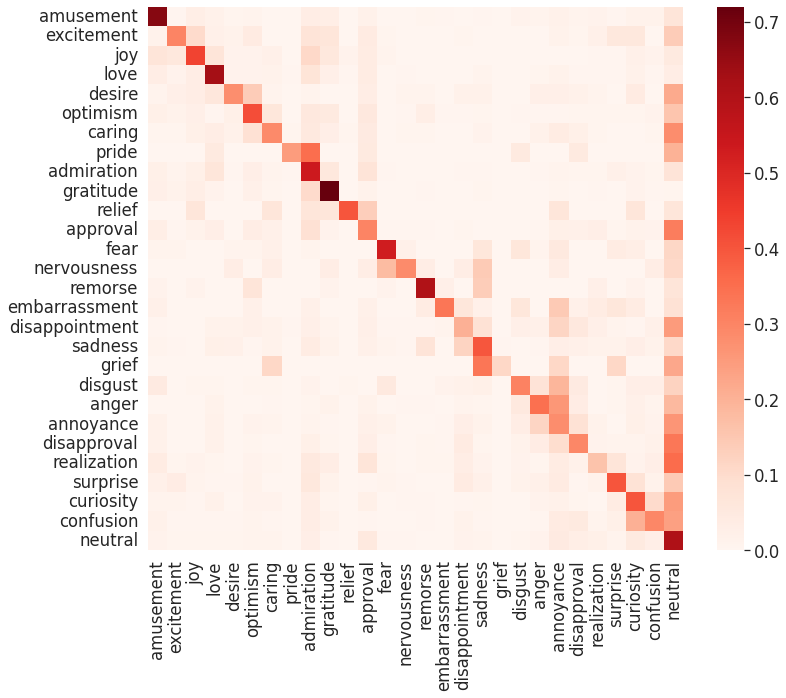

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

group = {
"positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}

order = group["positive"] + group["negative"] + group["ambiguous"] + ['neutral']
ind = [label2id[i]  for i in order]

plt.figure(figsize = (12,10))
sns.set(font_scale=1.5)

conf_mat_plot = np.array(conf_mat / np.sum(conf_mat, axis = 1).reshape(-1,1))
conf_mat_plot = conf_mat_plot[ind][:,ind]
sns.heatmap(conf_mat_plot, cmap = 'Reds', xticklabels = np.array(LABELS)[ind], yticklabels = np.array(LABELS)[ind])

plt.savefig('confusion_matrix.pdf')


In [27]:

conf_exp = conf_mat_plot
summary = [[np.sum(row[:12]), np.sum(row[12:23]), np.sum(row[23:27]), row[-1]] for row in conf_exp]


summary

np.mean(summary[12:23], axis = 0)

array([0.10560883, 0.65666037, 0.0688446 , 0.16888621])

<ipython-input-28-82b5b67df820>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_labels = np.array(dataset['test']['labels'] + dataset['train']['labels'] + dataset['validation']['labels'])


63812
[16 21 23 19 12 24 14  8 11 13 26  5 22  9 25  6 17  2 20 18 10  7  1  3
 15  4  0 27]
[   96   142   182   208   375   669   764   801  1013  1052  1330  1375
  1382  1583  1625  1673  1785  1960  1976  2576  2581  2723  2895  3093
  3372  3687  5122 17772]


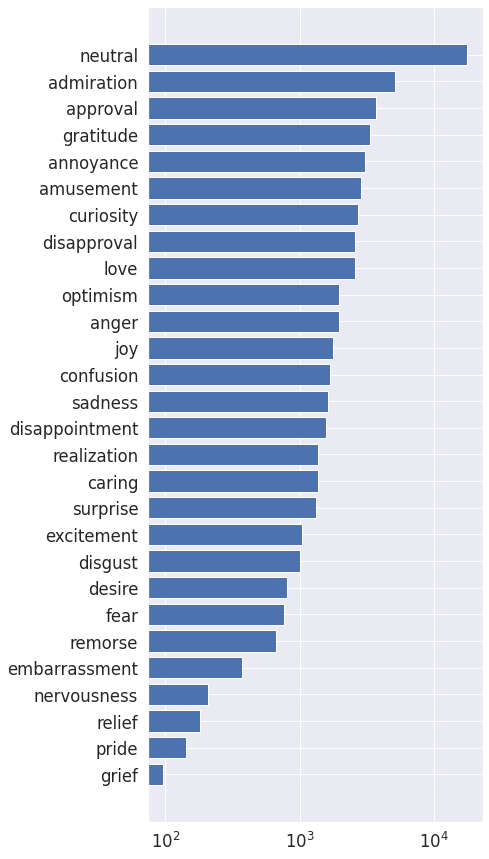

In [28]:
all_labels = np.array(dataset['test']['labels'] + dataset['train']['labels'] + dataset['validation']['labels'])
all_labels = np.concatenate(all_labels)
print(len(all_labels))
labels_count = [np.sum(np.where(all_labels == l, 1, 0)) for l in range(0,28)]
ind = np.argsort(labels_count)
print(ind)
plt.figure(figsize = (6,15))
print(np.array(labels_count)[ind])
plt.barh(np.arange(28), np.array(labels_count)[ind], tick_label = np.array(LABELS)[ind], orientation = 'horizontal', log = True)
plt.savefig('label_distribution.pdf')
